# Color quantization & first evaluation of color histogram classifier

In [7]:
# deactivate buggy jupyter completion
%config Completer.use_jedi = False

In [41]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os
from ipywidgets import interact
import ipywidgets as widgets
import sklearn.cluster
import random

In [9]:
PATH_TO_RESOURCES = "./data/train" # Adapt to your data folder

In [10]:
def get_image(dir_: str, filename: str) -> np.array:
    img = cv2.imread(os.path.join(PATH_TO_RESOURCES, dir_, filename))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [11]:
X = np.array([
    get_image(dir_, filename)
    for dir_ in os.listdir(PATH_TO_RESOURCES)
    for filename in os.listdir(os.path.join(PATH_TO_RESOURCES, dir_))
], dtype=object)
Y = np.array([
    int(dir_)
    for dir_ in os.listdir(PATH_TO_RESOURCES)
    for filename in os.listdir(os.path.join(PATH_TO_RESOURCES, dir_))
])
X.shape, Y.shape

((285,), (285,))

In [12]:
nb_class = np.max(Y)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
    for i, x in enumerate(X[Y == class_]):
        ax_arr[i].imshow(x)

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

# Color reduction

## Image mask

In [13]:
gray_threshold = 245

masks = np.array([
    img.sum(axis=-1) < (gray_threshold * 3)
    for img in X
], dtype=object)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
    for i, mask in enumerate(masks[Y == class_]):
        ax_arr[i].imshow(mask, cmap='gray')

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

## Selecting random pixels

In [14]:
nb_sample = 50000

nb_images = nb_class * 5
nb_sample_per_image = nb_sample // nb_images

sample_pxls = X[0][masks[0]][0] # Initialize arbitrary to be able to use np.vstack
for img, mask in zip(X[1:], masks[1:]):
    pxls = img[mask]
    new_sample_pxls_id = np.random.choice(pxls.shape[0], size=nb_sample_per_image, replace=False)
    sample_pxls = np.vstack((sample_pxls, pxls[new_sample_pxls_id]))

sample_pxls.shape, sample_pxls.dtype

((49701, 3), dtype('uint8'))

## Selecting sampling color

In [15]:
from sklearn.cluster import KMeans

2


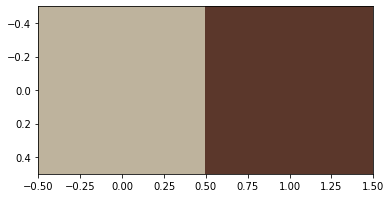

3


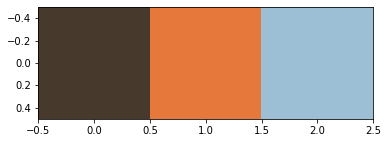

4


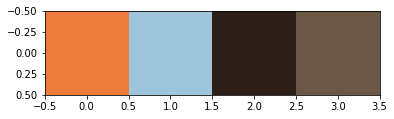

5


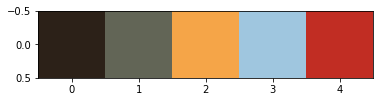

6


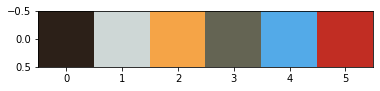

7


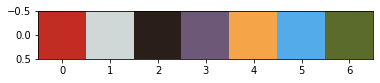

8


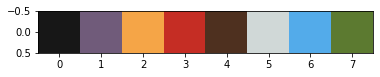

9


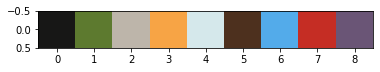

10


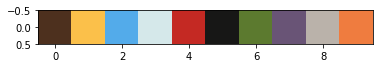

11


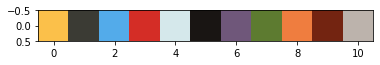

12


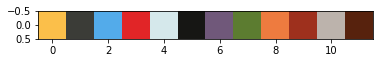

13


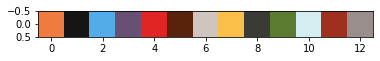

In [16]:
# How to choose the right number of colors ?

inertias = []
for i in range(2, 14):
    print(i)
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(sample_pxls)
    inertias.append(kmeans.inertia_)
    
    new_color = kmeans.cluster_centers_.astype(np.uint8)
    plt.imshow(new_color[np.newaxis, :, :])
    plt.show()

[[194  44  35]
 [207 216 215]
 [ 42  30  24]
 [110  88 120]
 [245 164  71]
 [ 83 171 234]
 [ 90 107  44]]


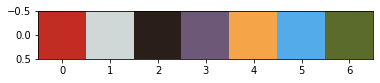

In [17]:
# Example of color sampling
nb_color = 7

kmeans = KMeans(n_clusters=nb_color, random_state=42)
kmeans.fit(sample_pxls)
new_color_lut = kmeans.cluster_centers_.astype(np.uint8)

print(new_color_lut)
plt.imshow(new_color_lut[np.newaxis, :, :]);

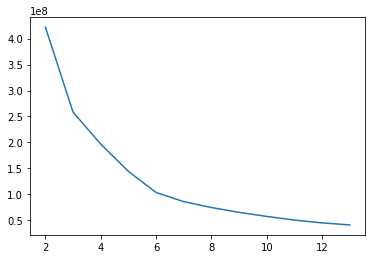

In [18]:
plt.plot(range(2, 14), inertias)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Use the `KMeans` object and super fancy Numpy indexing to create a new image where the color of each pixel is the color of the closest cluster to the original pixel color.**

Tip:
- Do not forget to mask the background of the image during prediction (because we did not train the predictor on them).
- Start by producing a new image with cluster labels instead of color values.
- Then create a color lookup table (LUT) using cluster centers (make sure to use `np.uint8` values to avoid issues with later conversion).
- Finally use Numpy advanced indexing to apply the LUT to the image with cluster labels.
</div>

In [19]:
color_maps = np.array([
    kmeans.predict(img[mask])
    for img, mask in zip(X, masks)
], dtype=object)
color_maps[0]

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [20]:
def get_recolored_img(img: np.array, mask: np.array, color_map: np.array) -> np.array:
    recolored_img = np.full_like(img, 255)
    recolored_img[mask] = new_color_lut[color_map]
    
    return recolored_img

recolored_X = np.array([
    get_recolored_img(img, mask, color_map)
    for img, mask, color_map in zip(X, masks, color_maps)
], dtype=object)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=2, ncols=5, figsize=(12,4))
    for i, (recolored_x, x) in enumerate(zip(recolored_X[Y == class_], X[Y == class_])):
        ax_arr[0, i].imshow(recolored_x)
        ax_arr[1, i].imshow(x)

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

## Compute the color histograms

In [21]:
def get_hist(color_map: np.array) -> np.array:
    hist = np.bincount(color_map, minlength=nb_color)
    norm_hist = hist / color_map.shape[0]
    
    return norm_hist

color_histograms = np.array([get_hist(color_map) for color_map in color_maps], dtype=object)
color_histograms[0]

array([0.21233058729736912, 0.25707547169811323, 0.15685623173000265,
       0.018834706351315438, 0.295110284347595, 0.0, 0.05979271857560457],
      dtype=object)

In [22]:
colors_for_bars = new_color_lut / 255  # matplotlib colors are RGB values scaled to [0,1]

@interact(x_index=widgets.BoundedIntText(max=X.shape[0]))
def show_histograms(x_index: int) -> None:
    plt.figure(figsize=(8,4))
    plt.subplot(1,3,1)
    plt.imshow(X[x_index])
    plt.axis('off'); plt.title("Original")
    plt.subplot(1,3,2)
    plt.imshow(recolored_X[x_index])
    plt.axis('off'); plt.title("Recolored")
    plt.subplot(1,3,3, aspect=len(color_histograms[0]))
    plt.ylim(0, 1)
    plt.bar(range(len(color_histograms[x_index])), 
            color_histograms[x_index] / color_histograms[x_index].max(), 
            color=colors_for_bars)
    plt.xticks([]); plt.title("Histogram")
    plt.show()

interactive(children=(BoundedIntText(value=0, description='x_index', max=285), Output()), _dom_classes=('widge…

## Compute the distance matrix
Because color histograms are **very compact**, it is **very fast** to compute the distance matrix (even if the complexity is $O(n^2)$).

In [23]:
from scipy.spatial.distance import cosine

dist_mat = np.ones((len(X), len(X))) # distances will be between 0 (closest) and 1 (farthest)
for i in range(len(X)):
    for j in range(len(X)):
        dist_mat[i,j] = cosine(color_histograms[i], color_histograms[j])

Correct the diagonal to avoid getting the same result over and over: we set the distance of one element against itself to the maximum distance.

In [24]:
dist_mat[np.diag_indices_from(dist_mat)] = 1

In [25]:
idx_of_best_matches_per_row = np.argsort(dist_mat, axis=1)

## Find the best matches for each image

In [26]:
nb_images_displayed = 5

@interact(x_index=widgets.BoundedIntText(max=X.shape[0] - 1))
def show_similar_images(x_index: int) -> None:
    plt.figure(figsize=(12,8))
    nb_columns = nb_images_displayed + 1
    
    plt.subplot(1, nb_columns, 1)
    plt.imshow(X[x_index])
    plt.axis("off")
    plt.title("Original")
    
    for image_id in range(nb_images_displayed):
        idx = idx_of_best_matches_per_row[x_index, image_id]
        plt.subplot(1, nb_columns, image_id + 2)
        plt.imshow(recolored_X[idx])
        plt.axis("off")
        plt.title(f"({dist_mat[x_index, idx]: .3f})")

interactive(children=(BoundedIntText(value=0, description='x_index', max=284), Output()), _dom_classes=('widge…

In [27]:
np.arange(nb_images)[Y == 55]

array([140, 141, 142, 143, 144])

A priori le nb de trous n'est pas ideal en second discriminateur. Contre-example:
- 0
- Peut-etre le 10 (jsp si 2 ou 3 trous)

Idees d'amelioration:
- Tester d'autres distances
- Reduire la "Color quantization" (a.k.a augmenter le nbr de couleurs) pour avoir une distance d'histogramme plus perinente
- Discrimineur de formes
- Tester
    - Soit d'augmenter le nombre de couleurs pour avoir un histogram + precis
    - Soit de tester des discriminateurs de formes

In [121]:
seed = 7
kmean = sklearn.cluster.KMeans(57, random_state=seed)

h_inertias = []
for i in range(1, nb_class):
    kmeans = KMeans(n_clusters=i, random_state=seed)
    kmeans.fit(color_histograms)
    h_inertias.append(kmeans.inertia_)

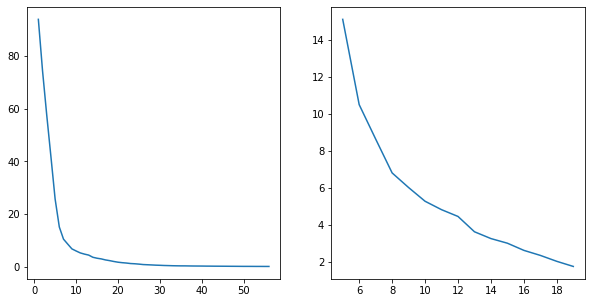

In [126]:
_, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax_arr[0].plot(range(1,nb_class), h_inertias)
ax_arr[1].plot(range(5,20), h_inertias[5:20])
nb_wanted_classes = 13

We see that inertia decrease way slower when the number of clusters becomes higher than 6, by zooming in that area we decided to take 13 clusters.

In [124]:
kmean = sklearn.cluster.KMeans(nb_wanted_classes, random_state=seed)
kmean.fit(color_histograms)
predictions = kmean.predict(color_histograms)

In [125]:
@interact(class_=widgets.BoundedIntText(min=1, max=nb_wanted_classes - 1))
def print_class(class_: int) -> None:
    cluster_mask = predictions == class_
    nb_images = np.sum(cluster_mask)
    if (nb_images == 0):
        print("Aucune image pour ce cluster.")
        return

    nb_rows = (nb_images + 4) // 5
    _, ax_arr = plt.subplots(nrows=max(nb_rows, 2), ncols=5, figsize=(10, 2 * nb_rows))
    for i, x in enumerate(X[np.where(cluster_mask)[0]]):
        ax_arr[i // 5, i % 5].axis("off")
        ax_arr[i // 5, i % 5].imshow(x)

    for i in range(5):
        ax_arr[-1, i].axis("off")


interactive(children=(BoundedIntText(value=1, description='class_', max=12, min=1), Output()), _dom_classes=('…